In [1]:
!pip install kaggle

In [6]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("vivek468/superstore-dataset-final")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'superstore-dataset-final' dataset.
Path to dataset files: /kaggle/input/superstore-dataset-final


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns           # optional for nicer plots (installed in Colab)
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
import joblib


In [17]:
df =pd.read_csv('/content/sample_data/california_housing_train.csv')

In [19]:
print("Rows, cols:", df.shape)
display(df.head())
display(df.info())
display(df.describe(include='all').T)


Rows, cols: (17000, 9)


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           17000 non-null  float64
 1   latitude            17000 non-null  float64
 2   housing_median_age  17000 non-null  float64
 3   total_rooms         17000 non-null  float64
 4   total_bedrooms      17000 non-null  float64
 5   population          17000 non-null  float64
 6   households          17000 non-null  float64
 7   median_income       17000 non-null  float64
 8   median_house_value  17000 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


None

,count,mean,std,min,25%,50%,75%,max
longitude,17000.0,-119.562108,2.005166,-124.3500,-121.790000,-118.4900,-118.000,-114.3100
latitude,17000.0,35.625225,2.137340,32.5400,33.930000,34.2500,37.720,41.9500
housing_median_age,17000.0,28.589353,12.586937,1.0000,18.000000,29.0000,37.000,52.0000
total_rooms,17000.0,2643.664412,2179.947071,2.0000,1462.000000,2127.0000,3151.250,37937.0000
total_bedrooms,17000.0,539.410824,421.499452,1.0000,297.000000,434.0000,648.250,6445.0000
population,17000.0,1429.573941,1147.852959,3.0000,790.000000,1167.0000,1721.000,35682.0000
households,17000.0,501.221941,384.520841,1.0000,282.000000,409.0000,605.250,6082.0000
median_income,17000.0,3.883578,1.908157,0.4999,2.566375,3.5446,4.767,15.0001
median_house_value,17000.0,207300.912353,115983.764387,14999.0000,119400.000000,180400.0000,265000.000,500001.0000


In [20]:

# Check column names and types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           17000 non-null  float64
 1   latitude            17000 non-null  float64
 2   housing_median_age  17000 non-null  float64
 3   total_rooms         17000 non-null  float64
 4   total_bedrooms      17000 non-null  float64
 5   population          17000 non-null  float64
 6   households          17000 non-null  float64
 7   median_income       17000 non-null  float64
 8   median_house_value  17000 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


In [21]:
# Summary stats
df.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,17000.0,-119.562108,2.005166,-124.3500,-121.790000,-118.4900,-118.000,-114.3100
latitude,17000.0,35.625225,2.137340,32.5400,33.930000,34.2500,37.720,41.9500
housing_median_age,17000.0,28.589353,12.586937,1.0000,18.000000,29.0000,37.000,52.0000
total_rooms,17000.0,2643.664412,2179.947071,2.0000,1462.000000,2127.0000,3151.250,37937.0000
total_bedrooms,17000.0,539.410824,421.499452,1.0000,297.000000,434.0000,648.250,6445.0000
population,17000.0,1429.573941,1147.852959,3.0000,790.000000,1167.0000,1721.000,35682.0000
households,17000.0,501.221941,384.520841,1.0000,282.000000,409.0000,605.250,6082.0000
median_income,17000.0,3.883578,1.908157,0.4999,2.566375,3.5446,4.767,15.0001
median_house_value,17000.0,207300.912353,115983.764387,14999.0000,119400.000000,180400.0000,265000.000,500001.0000


In [22]:
# Check missing values
df.isnull().sum()

,0
longitude,0
latitude,0
housing_median_age,0
total_rooms,0
total_bedrooms,0
population,0
households,0
median_income,0
median_house_value,0


In [23]:
# 'total_bedrooms' usually has missing values
print("Missing in total_bedrooms:", df['total_bedrooms'].isna().sum())

# Option 1: Fill missing with median
df['total_bedrooms'].fillna(df['total_bedrooms'].median(), inplace=True)


Missing in total_bedrooms: 0


/tmp/ipython-input-211877091.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['total_bedrooms'].fillna(df['total_bedrooms'].median(), inplace=True)


In [24]:
# Create new features
df['rooms_per_household'] = df['total_rooms'] / df['households']
df['bedrooms_per_room']   = df['total_bedrooms'] / df['total_rooms']
df['population_per_household'] = df['population'] / df['households']


In [25]:
# Cap extreme values in median_income (99th percentile)
upper_limit = df['median_income'].quantile(0.99)
df['median_income'] = np.where(df['median_income'] > upper_limit, upper_limit, df['median_income'])


In [28]:
# Save cleaned dataset
df.to_csv("/content/sample_data/california_housing_train.csv", index=False)
print("✅ Cleaned dataset saved as housing_cleaned")


✅ Cleaned dataset saved as housing_cleaned


In [30]:
# Features & Target
X = df.drop("median_house_value", axis=1)
y = df["median_house_value"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (13600, 11) Test shape: (3400, 11)


In [32]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")


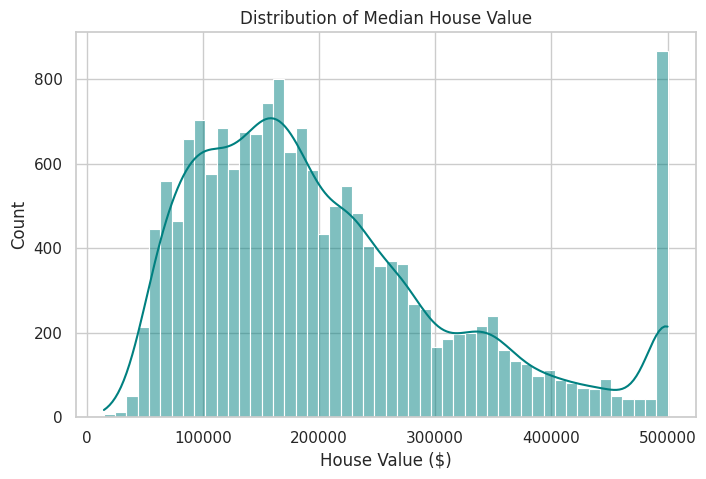

In [34]:
plt.figure(figsize=(8,5))
sns.histplot(df['median_house_value'], bins=50, kde=True, color="teal")
plt.title("Distribution of Median House Value")
plt.xlabel("House Value ($)")
plt.ylabel("Count")
plt.show()


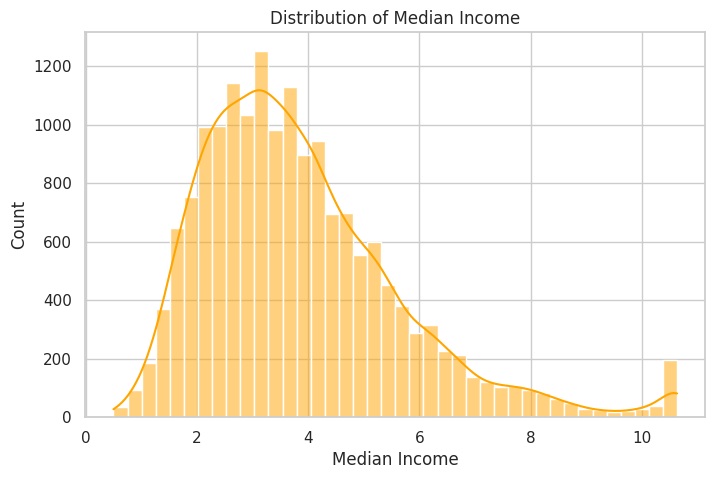

In [35]:
plt.figure(figsize=(8,5))
sns.histplot(df['median_income'], bins=40, kde=True, color="orange")
plt.title("Distribution of Median Income")
plt.xlabel("Median Income")
plt.ylabel("Count")
plt.show()


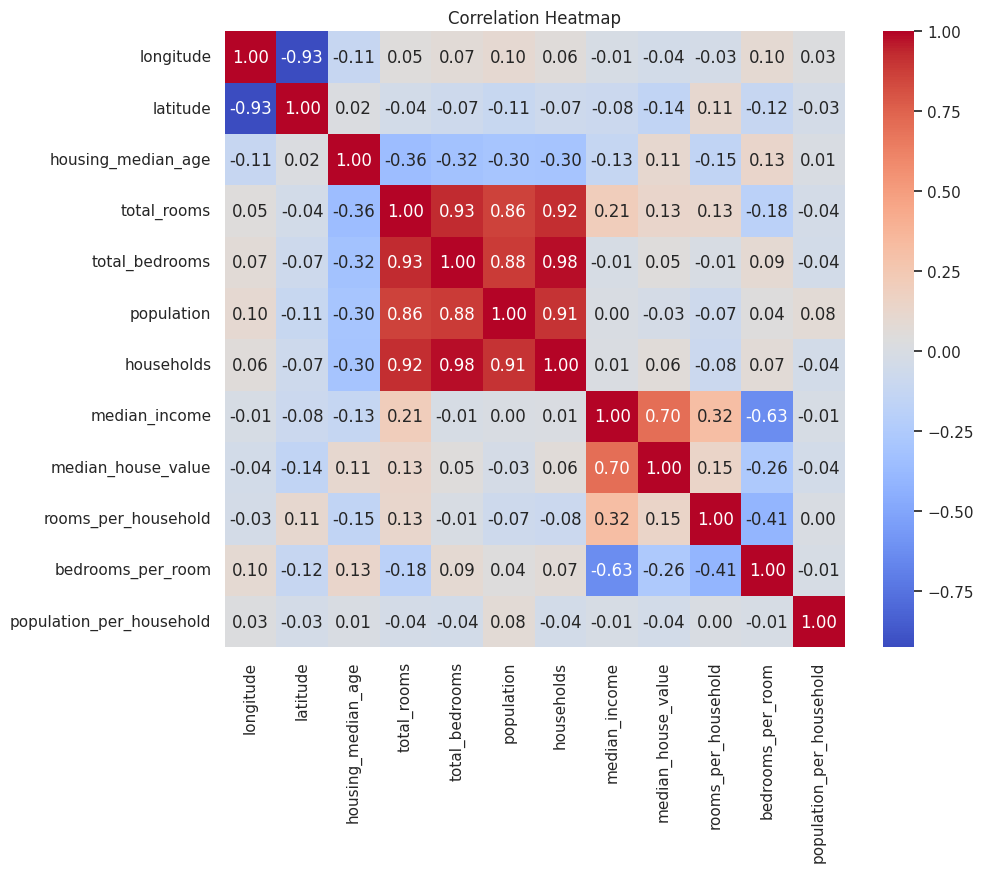

In [36]:
plt.figure(figsize=(10,8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


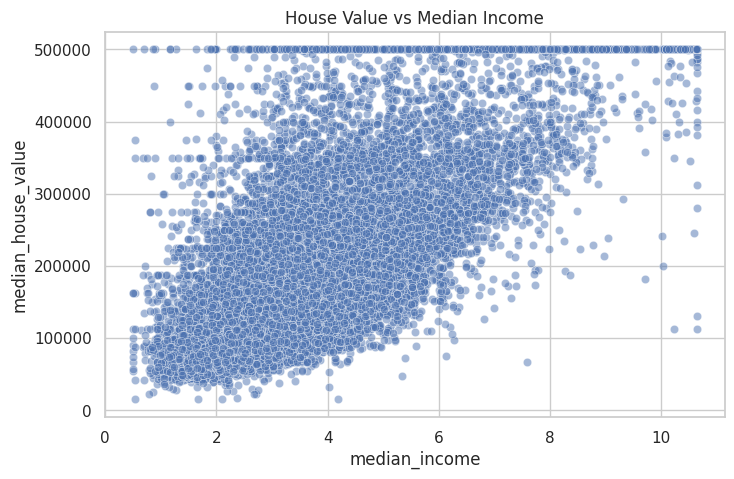

In [37]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="median_income", y="median_house_value", data=df, alpha=0.5)
plt.title("House Value vs Median Income")
plt.show()


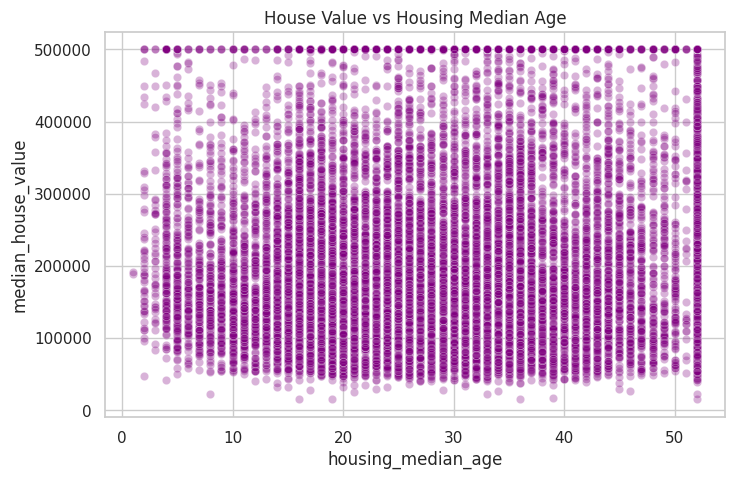

In [38]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="housing_median_age", y="median_house_value", data=df, alpha=0.3, color="purple")
plt.title("House Value vs Housing Median Age")
plt.show()


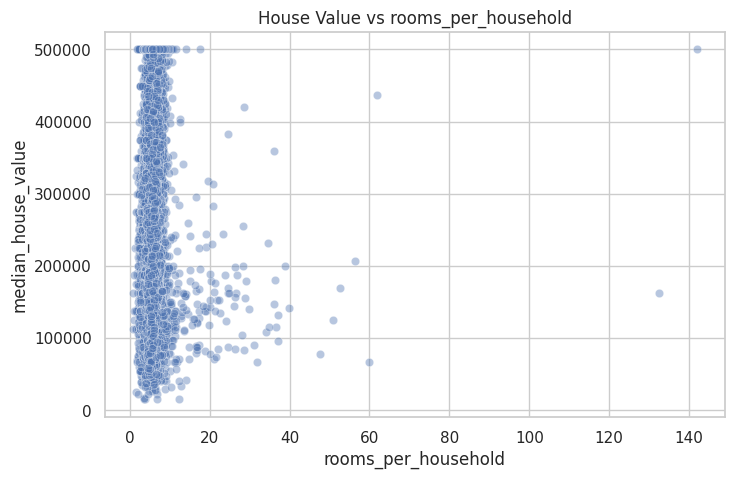

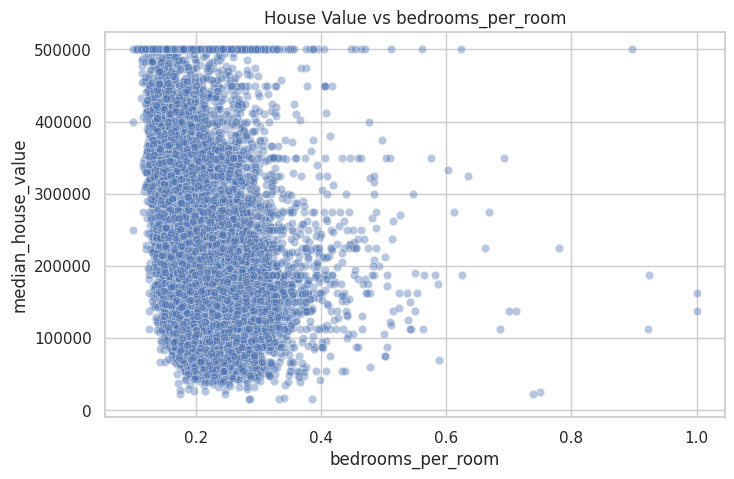

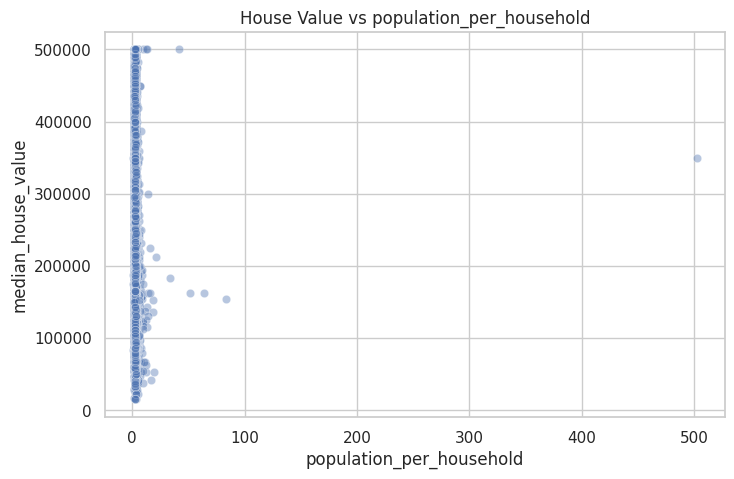

In [41]:
for col in ["rooms_per_household", "bedrooms_per_room", "population_per_household"]:
    if col in df.columns:
        plt.figure(figsize=(8,5))
        sns.scatterplot(x=col, y="median_house_value", data=df, alpha=0.4)
        plt.title(f"House Value vs {col}")
        plt.show()


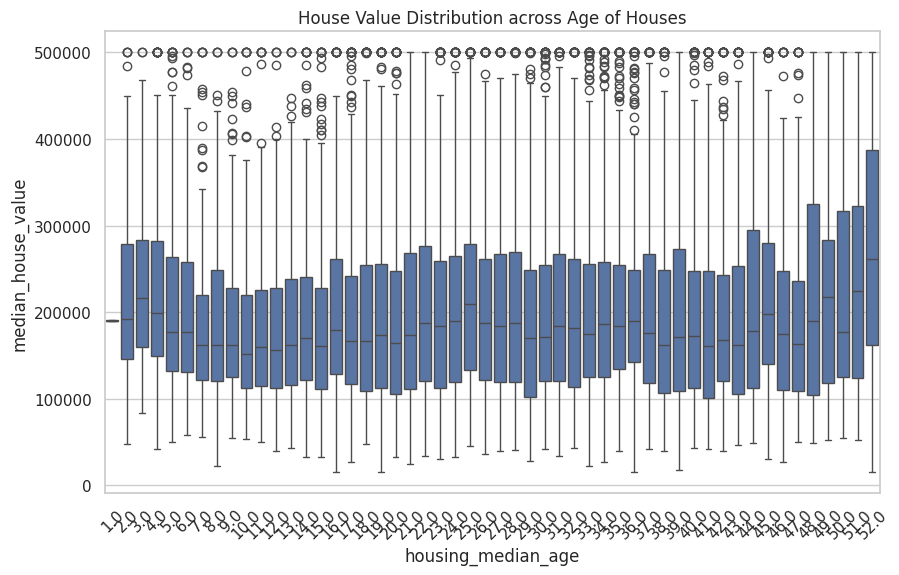

In [43]:
plt.figure(figsize=(10,6))
sns.boxplot(x="housing_median_age", y="median_house_value", data=df)
plt.title("House Value Distribution across Age of Houses")
plt.xticks(rotation=45)
plt.show()


In [44]:
# Compute correlation with target
corr_target = df.corr(numeric_only=True)['median_house_value'].sort_values(ascending=False)

print("Correlation with Median House Value:\n")
print(corr_target)


Correlation with Median House Value:

median_house_value          1.000000
median_income               0.699428
rooms_per_household         0.150081
total_rooms                 0.130991
housing_median_age          0.106758
households                  0.061031
total_bedrooms              0.045783
population                 -0.027850
population_per_household   -0.042764
longitude                  -0.044982
latitude                   -0.144917
bedrooms_per_room          -0.258190
Name: median_house_value, dtype: float64


> ### 📝 Interpretation Summary (Insights)
>
> **Income drives price**  
> - Median Income is the most important metric (correlation ~0.7).  
> - Policy makers or investors can use this to identify high-value zones.  
>
> **Location matters**  
> - Houses closer to the coast (low longitude/latitude) have higher prices.  
> - Confirms the real-estate principle: *location is everything*.  
>
> **Space efficiency matters more than raw counts**  
> - `rooms_per_household` → positive relationship.  
> - `bedrooms_per_room` → negative (inefficient layout, lower value).  
>
> **Age has limited impact**  
> - Older houses don’t drastically reduce value — sometimes higher if in prime location.  
>
> **Population density reduces value**  
> - Overcrowded areas (`population_per_household`) show lower prices.  
